In [142]:
!pip install --upgrade kagglehub[pandas-datasets,hf-datasets]

In [143]:

!apt-get install git -y

!git clone https://github.com/miriam-16/aml_1_aerial_imagery.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 122 not upgraded.
fatal: destination path 'aml_1_aerial_imagery' already exists and is not an empty directory.


In [144]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline

In [145]:
path = "/kaggle/working/aml_1_aerial_imagery/dataset"
import pandas as pd

labels_df = pd.read_csv(path+'/train.csv')  # Adjust filename
print(labels_df.head())


                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1


In [146]:
print(labels_df.shape)
labels_df[labels_df.duplicated(keep=False)]


(17500, 2)


,id,has_cactus


In [147]:
labels_df['has_cactus'].value_counts()

has_cactus
1    13136
0     4364
Name: count, dtype: int64

In [148]:
import torch
torch.manual_seed(0)

from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms

class pytorch_data(Dataset):
    
    def __init__(self, data_dir, transform, data_type="train"):
        # Get Image File Names
        cdm_data = os.path.join(data_dir, data_type)
        file_names = os.listdir(cdm_data)

        all_image_paths = [os.path.join(cdm_data, f) for f in file_names if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        print(f"Found {len(all_image_paths)} images in directory.")
        print(f"Sample filenames: {all_image_paths[:1]}")

        # Get Labels
        labels_data = os.path.join("/kaggle/working/aml_1_aerial_imagery/dataset/", "train.csv")
        labels_df = pd.read_csv(labels_data)

        # Normalize index: remove extensions if present
        labels_df['id'] = labels_df['id'].apply(lambda x: os.path.splitext(str(x))[0])
        labels_df.set_index("id", inplace=True)

        print(f"Labels dataframe length: {len(labels_df)}")

        # Extract only valid images (that have a label)
        valid_filenames = []
        labels = []

        for f in all_image_paths:
            filename = os.path.basename(f)  # get only file name
            image_id = os.path.splitext(filename)[0]  # remove extension

            if image_id in labels_df.index:
                valid_filenames.append(f)
                labels.append(labels_df.loc[image_id].values[0])
            else:
                print(f"Warning: image '{filename}' has no matching label in train.csv")

        self.full_filenames = valid_filenames
        self.labels = labels
        self.transform = transform

        print(f"Valid image-label pairs: {len(self.full_filenames)}")
        print(f"First few labels: {self.labels[:5]}")
      
    def __len__(self):
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        if idx >= len(self.full_filenames):
            raise IndexError(f"Index {idx} out of bounds for dataset of length {len(self.full_filenames)}")

        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

In [149]:
# define transformation that converts a PIL image into PyTorch tensors
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((32,32))])


In [150]:
# Define an object of the custom dataset for the train folder.
data_dir = path+'/train/'
img_dataset = pytorch_data(data_dir, data_transformer, "train")

Found 17500 images in directory.
Sample filenames: ['/kaggle/working/aml_1_aerial_imagery/dataset/train/train/6603b0d80a40a56d87904b4e03784536.jpg']
Labels dataframe length: 17500
Valid image-label pairs: 17500
First few labels: [1, 1, 0, 1, 0]


In [151]:
# define transformation that converts a PIL image into PyTorch tensors
data_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])

In [152]:
# Test a sample
img, label = img_dataset[10]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 32, 32]) tensor(0.0431) tensor(1.)


In [153]:
len_img=len(img_dataset)
len_train=int(0.7*len_img)
len_val=int(0.2*len_img)
len_test = int(0.1*len_img)
# Split Pytorch tensor
train_ts,val_ts, test_ts =random_split(img_dataset,
                             [len_train,len_val, len_test]) # random split 80/20

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))
print("test dataset size:", len(test_ts))

train dataset size: 12250
validation dataset size: 3500
test dataset size: 1750


In [154]:
# getting the torch tensor image & target variable
ii=-1
for x,y in train_ts:
    print(x.shape,y)
    ii+=1
    if(ii>5):
        break

torch.Size([3, 32, 32]) 1
torch.Size([3, 32, 32]) 1
torch.Size([3, 32, 32]) 0
torch.Size([3, 32, 32]) 1
torch.Size([3, 32, 32]) 0
torch.Size([3, 32, 32]) 0
torch.Size([3, 32, 32]) 1


In [155]:
import plotly.express as px

def plot_img(x,y,title=None):

    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(template='plotly_white')
    fig.update_layout(title=title,height=300,margin={'l':10,'r':20,'b':10})
    fig.show()

In [156]:
# Create grid of sample images 
grid_size=30
rnd_inds=np.random.randint(0,len(train_ts),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)
print(x_grid_train.shape)
    
plot_img(x_grid_train,y_grid_train,'Training Subset Examples')


image indices: [ 7842   481  1240  3181  8637  5492 11273  7840  1062  5884  1530  3955
  4985  6881   864  1493  2642  8880  1829  4762  4403  3006 11435  3104
  6525  5144 11165  4239 11665 10601]
torch.Size([3, 104, 342])


In [157]:
grid_size=30
rnd_inds=np.random.randint(0,len(val_ts),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ts[i][0] for i in range(grid_size)]
y_grid_val=[val_ts[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=10, padding=2)
print(x_grid_val.shape)

plot_img(x_grid_val,y_grid_val,'Validation Dataset Preview')

image indices: [2730 1213   53  715 1582  555 1814 1970 1984 3113 2600 1211 3177   62
 2566 3361 3110  805  220 3209 1782 2290 1091 2826 2192 2717 1757 3424
 2066 1701]
torch.Size([3, 104, 342])


In [158]:
# Define the following transformations for the training dataset
tr_transf = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.ToTensor()])

In [159]:
# For the validation dataset, we don't need any augmentation; simply convert images into tensors
val_transf = transforms.Compose([
    transforms.ToTensor()])

# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_ts.transform=tr_transf
val_ts.transform=val_transf

In [160]:
# The subset can also have transform attribute (if we asign)
train_ts.transform

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

In [161]:
from torch.utils.data import DataLoader

# Training DataLoader
train_dl = DataLoader(train_ts,
                      batch_size=64, 
                      shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts,
                    batch_size=64,
                    shuffle=False)

In [162]:
# check samples
for x,y in train_dl:
    print(x.shape,y)
    break

torch.Size([64, 3, 32, 32]) tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1])


In [163]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

import torch.nn as nn
import torch.nn.functional as F

# Neural Network
class Network(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(Network, self).__init__()
    
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3, padding=1)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,padding=1)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3, padding=1)
        h,w=findConv2dOutShape(h,w,self.conv3)
        
        # compute the flatten size
        self.num_flatten=h*w*4*init_f   #4*8 -> 32
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    

    def forward(self,X):
        
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)

        b = X.shape[0]
        X = X.view(b,-1) #torch appiattisce su tutti i canali, tranne il primo che corrisponde alla batch size
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [164]:
# Neural Network Predefined Parameters
params_model={
        "shape_in": (3,32,32), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = Network(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [165]:
X = torch.randn((64,3,32,32))
Y = model(X)
print(Y.shape)

torch.Size([64, 2])


In [166]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 32, 32),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
            Conv2d-2           [-1, 16, 16, 16]           1,168
            Conv2d-3             [-1, 32, 8, 8]           4,640
            Linear-4                  [-1, 100]          51,300
            Linear-5                    [-1, 2]             202
Total params: 57,534
Trainable params: 57,534
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.22
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


In [167]:
loss_func = nn.NLLLoss(reduction="sum")

In [168]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20)

In [169]:
''' Helper Functions'''

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [170]:
from tqdm.notebook import trange, tqdm

def train_val(model, params,verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value
    
    ''' Train Model n_epochs '''
    
    for epoch in tqdm(range(epochs)):
        
        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        '''
        
        Train Model Process
        
        '''
        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        '''
        
        Evaluate Model Process
        
        '''
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [171]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

''' Actual Train / Evaluation of CNN Model '''
# train and validate the model

cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

Text(0.5, 1.0, 'Convergence History')

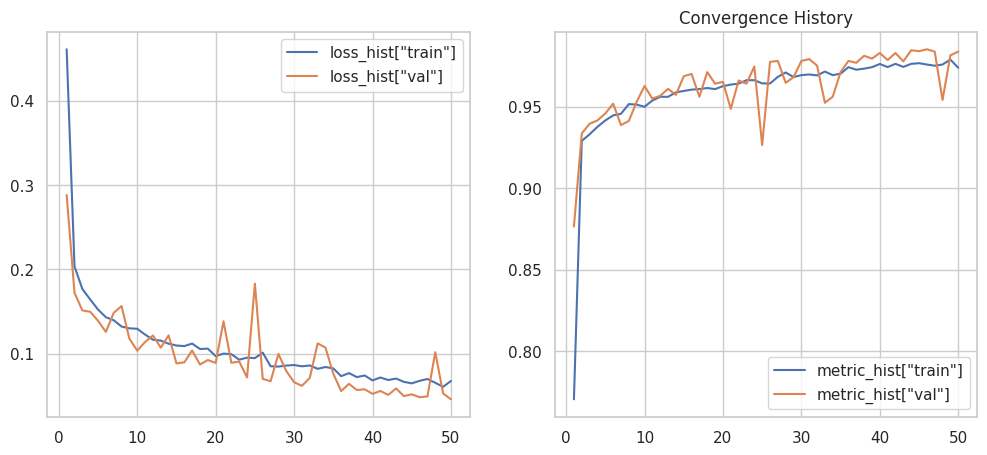

In [172]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')
plt.title('Convergence History')


In [173]:
class pytorchdata_test(Dataset):
    
    def __init__(self, data_dir, transform,data_type="train"):
        
        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # labels are in a csv file named train_labels.csv
        csv_filename="sample_submission.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename].values[0] for filename in filenames]
        self.transform = transform       
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [174]:
!ls

aml_1_aerial_imagery  weights.pt


In [175]:
!ls '/kaggle/working/aml_1_aerial_imagery/dataset/test/test' | head -n 5


000940378805c44108d287872b2f04ce.jpg
0017242f54ececa4512b4d7937d1e21e.jpg
001ee6d8564003107853118ab87df407.jpg
002e175c3c1e060769475f52182583d0.jpg
0036e44a7e8f7218e9bc7bf8137e4943.jpg
ls: write error: Broken pipe


In [176]:
cnn_model.load_state_dict(torch.load('weights.pt'))

/tmp/ipykernel_31/644530047.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

In [177]:
# sample submission
path_sub = "/kaggle/working/aml_1_aerial_imagery/dataset/sample_submission.csv"
labels_df = pd.read_csv(path_sub)
labels_df.head()
labels_df.shape


(4000, 2)

In [178]:
data_dir = '/kaggle/working/aml_1_aerial_imagery/dataset/'

data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((32,32))])

img_dataset_test = pytorchdata_test(data_dir,data_transformer,data_type="test/test/")
print(len(img_dataset_test), 'samples found')

4000 samples found


In [179]:
def inference(model,dataset,device,num_classes=2):
    
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) # initialize output tensor on CPU
    y_gt=np.zeros((len_data),dtype="uint8") # initialize ground truth on CPU
    model=model.to(device) # move model to device
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt     

In [189]:
y_test_out,y_test_gt = inference(cnn_model,img_dataset_test, device)            

  0%|          | 0/4000 [00:00<?, ?it/s]

In [190]:
# class predictions 0,1
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)
print(y_test_pred[0:5])

(4000,)
[0 1 1 1 1]


In [182]:
# probabilities of predicted selection
# return F.log_softmax(x, dim=1) ie.
preds = np.exp(y_test_out[:, 1])
print(preds.shape)
print(preds[0:5])


(4000,)
[0.00350931 0.99967444 0.9986934  0.9999994  0.99114555]


In [183]:
def plot_fig(ids,title,nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = (j +'.jpg')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

In [184]:
print(img_dataset_test.full_filenames[0:5])

['/kaggle/working/aml_1_aerial_imagery/dataset/test/test/fb66a2521a1b746ee1c4ffac4e10f019.jpg', '/kaggle/working/aml_1_aerial_imagery/dataset/test/test/1288d1689880a9f0ad17c047575d85b8.jpg', '/kaggle/working/aml_1_aerial_imagery/dataset/test/test/3b5b13175204d092787ff2ec50b270de.jpg', '/kaggle/working/aml_1_aerial_imagery/dataset/test/test/51f2eebc2d7fe3ebf67db559394aa7e7.jpg', '/kaggle/working/aml_1_aerial_imagery/dataset/test/test/0c8b37ee4244dc3199228255f3376a81.jpg']


In [185]:
first_samples = [path[:-4] for path in img_dataset_test.full_filenames[0:5]]

In [186]:
print(first_samples)

['/kaggle/working/aml_1_aerial_imagery/dataset/test/test/fb66a2521a1b746ee1c4ffac4e10f019', '/kaggle/working/aml_1_aerial_imagery/dataset/test/test/1288d1689880a9f0ad17c047575d85b8', '/kaggle/working/aml_1_aerial_imagery/dataset/test/test/3b5b13175204d092787ff2ec50b270de', '/kaggle/working/aml_1_aerial_imagery/dataset/test/test/51f2eebc2d7fe3ebf67db559394aa7e7', '/kaggle/working/aml_1_aerial_imagery/dataset/test/test/0c8b37ee4244dc3199228255f3376a81']


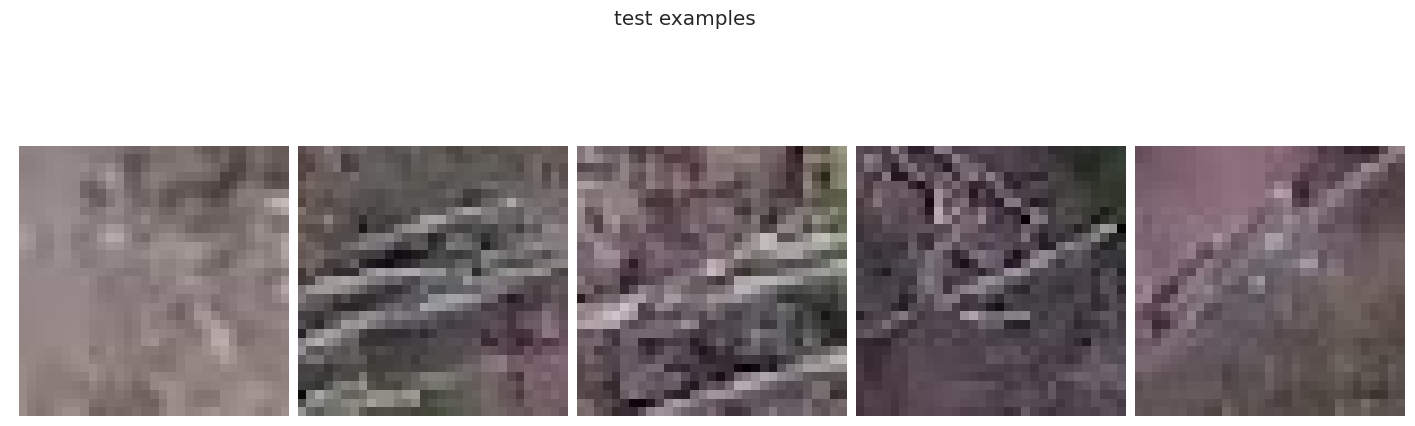

In [187]:
plot_fig(first_samples, "test examples",nrows=1, ncols=5)

In [199]:
result = np.argmax(y_test_out) == y_test_gt
result = result.sum()
test_accuracy = result / y_test_gt.size

In [201]:
print(result)
print(test_accuracy)

0
0.0


In [203]:
print(y_test_gt)

print(y_test_gt.max())

[0 0 0 ... 0 0 0]
0
